# Projet SD-WAN-ReinforcementLearning

# Partie: Recherche opérationnelle

In [ ]:
#!pip install pulp

Imports

In [1]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

np.random.seed(1)

### Generation of random graph

In [2]:
def image_nertworkx(nodes = 25, edges = 4):
    g = nx.to_directed(nx.fast_gnp_random_graph(nodes,edges/nodes,directed=True))

    check_list = []
    for i, j in g.edges:
        if i not in check_list:
            check_list.append(i)
    for ii in range(nodes):
        if ii not in check_list:
            g = image_nertworkx(nodes , edges)
    return g

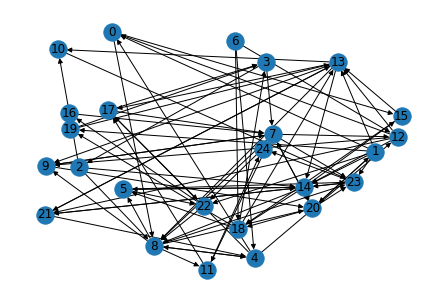

In [3]:
g = image_nertworkx()

node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
#plt.savefig("images/original.jpg")
plt.show()

### Generation of random attributes for the graph edges

In [4]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [5]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(50.0, 200.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [6]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = dict_capa[i, j]-round(random.uniform(40.0, dict_capa[i, j]), 0)
    
nx.set_edge_attributes(g, dict_used, 'used')

In [7]:
# instantiate
list_keys = ['shortest_path','min_banwidth_sum']
nodes_models = {}

dict_res = defaultdict(dict)

In [8]:
source = 0
target = 24

In [9]:
Used_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    Used_df[s_link] = g.edges[link]['used']
Used_df

,0,0_8,0_15,1_0,1_13,1_14,1_19,1_20,1_22,1_23,...,20_23,21_4,21_13,21_14,22_8,22_16,23_14,23_21,23_24,24_22
0,0.0,75.0,13.0,30.0,54.0,9.0,83.0,66.0,118.0,11.0,...,50.0,132.0,23.0,8.0,44.0,143.0,17.0,13.0,10.0,99.0


In [10]:
Capa_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    Capa_df[s_link] = g.edges[link]['capacity']
Capa_df

,0,0_8,0_15,1_0,1_13,1_14,1_19,1_20,1_22,1_23,...,20_23,21_4,21_13,21_14,22_8,22_16,23_14,23_21,23_24,24_22
0,0.0,175.0,144.0,75.0,102.0,58.0,164.0,110.0,166.0,131.0,...,101.0,189.0,122.0,69.0,126.0,193.0,148.0,59.0,164.0,147.0


In [11]:
def new_iter_used(Used_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Used_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-2000,2000)/100
        else:
            random_value = bdw
            
        new_value = Used_df.iloc[-1,Used_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > g.edges[link]['capacity'] :
            new_value = g.edges[link]['capacity']

        New_iter[s_link] = new_value
    print(New_iter.head())
    New_iter.iloc[-1,0] = iter
    Used_df = Used_df.append(New_iter)
    return Used_df


In [12]:
def update_list_df(Used_df):
    list_used_df = []

    for i in g.nodes:
        df = pd.DataFrame()
        for j in Used_df.keys():
            if str(j).split('_')[0] == str(i):
                if len(str(j).split('_')) == 2:
                    df[str(j).split('_')[1]] = Used_df.iloc[:,Used_df.columns.get_loc(j)]
                
        df['Time'] = Used_df.iloc[:,0]
        list_used_df.append(df)
    return list_used_df

In [13]:
Used_df

,0,0_8,0_15,1_0,1_13,1_14,1_19,1_20,1_22,1_23,...,20_23,21_4,21_13,21_14,22_8,22_16,23_14,23_21,23_24,24_22
0,0.0,75.0,13.0,30.0,54.0,9.0,83.0,66.0,118.0,11.0,...,50.0,132.0,23.0,8.0,44.0,143.0,17.0,13.0,10.0,99.0


In [14]:
list_used_df = update_list_df(Used_df)
print(list_used_df[1])

      0    13   14    19    20     22    23  Time
0  30.0  54.0  9.0  83.0  66.0  118.0  11.0   0.0


In [15]:
## MARL Part

In [16]:
#Used_df = new_iter_used(Used_df,"0_23", 200)
Used_df

,0,0_8,0_15,1_0,1_13,1_14,1_19,1_20,1_22,1_23,...,20_23,21_4,21_13,21_14,22_8,22_16,23_14,23_21,23_24,24_22
0,0.0,75.0,13.0,30.0,54.0,9.0,83.0,66.0,118.0,11.0,...,50.0,132.0,23.0,8.0,44.0,143.0,17.0,13.0,10.0,99.0


In [17]:
def init_colors():
    color = {}
    for i, j in g.edges:
        color[i, j] = color[j, i] = (0,0,0,0.5)

    nx.set_edge_attributes(g, color, 'color')

In [18]:
def get_path_as_list_tuples(path):
    solve_var = [] 
    for i in path.split("_"):
        var = str(i).split('(')
        var = var[1].split(',')
        var[0] = int(var[0])
        var[1] = int(var[1].strip(')'))
        solve_var.append(tuple(var))
    return solve_var

In [19]:
def plot_graph(attributes):
    x = []
    y = []
    for i in range(iter_):
        x.append(dict_res[i][attributes])
        y.append(i)

    p = plt.plot(y, x)

    plt.show(p)
    plt.close()

In [20]:
def draw_path(solve_var):
        for link in g.edges:
            if link in solve_var:
                g.edges[link[0],link[1]]['color'] = (1,0,0,1) 
    
        colors = nx.get_edge_attributes(g,'color').values()

        nx.draw(g, pos = node_pose, 
            edge_color=colors, 
            with_labels=True)
        ## Save chosen path ##
        plt.show()
        #plt.savefig("imgs/Q_table/Q_table_iter_{}".format(iter))
        plt.close()
        init_colors()

In [21]:
def get_possible_actions(current_node):
    sub_list = []
    for (i,j) in g.edges:
        if i == current_node:
            sub_list.append((i,j))
    return sub_list

In [22]:
def get_list_possibles_nodes(current_node):
    sub_list = get_possible_actions(current_node)
    nodes_list = []
    for (i,j) in sub_list:
        nodes_list.append(j)
    #print(nodes_list)
    return nodes_list

In [23]:
def get_state(solve_var,add_dim = True):
    state = np.zeros((net.nodes,net.nodes), np.int8)
    for (i,j) in g.edges:
        if (i,j) in solve_var:
            state[i,j] = 1
        elif i == source:
            state[i,j] = 2
        elif j == target:
            state[i,j] = 2
        else:
            state[i,j] = 0
        if add_dim:
            state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        #print(state.shape)
        return state

In [24]:
def scale(x, out_range=(0, 1)):
    if len(x[0,0]) == 1:
        return [1]
    else :
        domain = np.min(x), np.max(x)
        y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
        return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [25]:
def get_epsilon():
    return (1.03 - iter_actuel / iter_ ) 

In [26]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense,Dropout, LSTM
from tensorflow.keras.optimizers import Adam

from math import floor

/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [27]:
dict_model = defaultdict(dict)
for i in g.nodes:
    cpt_output = 0
    
    #print("\n   Node : {}".format(i))
    
    for ii,j in g.edges:
        if (i == ii):
            #print("Edges Output : {}".format(j))
            dict_model[i][j] = g.edges[i, j]['used']
            cpt_output = cpt_output + 1
            
    dict_model[i]["cpt_output"] = cpt_output

In [28]:
def new_iter_used(Used_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Used_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-2000,2000)/100
            
        else:
            random_value = bdw
            
        new_value = Used_df.iloc[-1,Used_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > g.edges[link]['capacity'] :
            new_value = g.edges[link]['capacity']

        New_iter[s_link] = new_value
    New_iter.iloc[-1,0] = iter
    Used_df = Used_df.append(New_iter)
    return Used_df

In [29]:
def _build_compile_model(nodes_models,node):
    Used_df = pd.DataFrame(np.zeros((1,1)))
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        Used_df[s_link] = g.edges[link]['used']
    #Used_df= new_iter_Used(Used_df,-1, 0)

    list_model = update_list_df(Used_df)
    inputs = list_model[node]

    inputs = np.array(inputs).reshape(1, inputs.shape[1])
    inputs = np.append(inputs[0],target)
    inputs = np.array(inputs).reshape(1, inputs.shape[0])
    
    model = Sequential()

    model.add(LSTM(50, return_sequences = True, input_shape = (inputs.shape[0],inputs.shape[1])))
    model.add(Dropout(0.2))
    model.add(LSTM(25, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(Dense(10,activation='relu'))
    model.add(Dense(inputs.shape[1]-2,activation='softmax'))
    opt = Adam(learning_rate=0.05)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    nodes_models[node] = model
    return nodes_models
nodes_models = {}  
for i in range (25):
    nodes_models = _build_compile_model(nodes_models,i)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [60]:
Used_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = get_tuple_to_name(link)
    Used_df[s_link] = g.edges[link]['used']

list_model = update_list_df(Used_df)
inputs = list_model[0]
inputs = np.array(inputs).reshape(1, inputs.shape[1])

inputs = np.append(inputs[0],5)
inputs = np.array(inputs).reshape(1,1, inputs.shape[0])

for i in range (25):
    model = nodes_models[i]
    print(model.summary())

      (None, 1, 10)             260       
_________________________________________________________________
dense_65 (Dense)             (None, 1, 5)              55        
Total params: 19,515
Trainable params: 19,515
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 1, 50)             11200     
_________________________________________________________________
dropout_66 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 1, 25)             7600      
_________________________________________________________________
dropout_67 (Dropout)         (None, 1, 25)             0         
_________________________________________________________________
d

In [ ]:
model.predict(inputs)

In [30]:
def get_action(current_node):
    list_model = update_list_df(Used_df)
    
    inputs = list_model[current_node].iloc[-1,:]
    inputs = np.append(inputs,5)
    inputs = np.array(inputs).reshape(1,1, inputs.shape[0])
    expirience_replay[cpt] = inputs
 
    sub_list = get_possible_actions(current_node)
    #print("Possible actions from {} are {} ".format(current_node,sub_list))
    if np.random.rand() <= get_epsilon(): #Epsilon
        return random.choice(sub_list)[1]
    else :
        return get_model_action(current_node,inputs)

In [ ]:
get_action(0)

In [ ]:
print(expirience_replay[0])

In [31]:
def get_model_action(current_node,inputs):
    
    local_model = nodes_models[current_node]
    list_of_output = []
    for i in dict_model[current_node].keys():
        if i != 'cpt_output':
            list_of_output.append(i)

    pedicted_values = local_model.predict(inputs)
    #print(pedicted_values)
    
    value = np.argmax(pedicted_values[0])
    
    return list_of_output[value]


In [32]:
def get_indx_from_value(current_node,value):
    list_values = []
    for i,j in g.edges:
        if (current_node == i):
            list_values.append(j)
            
    return list_values.index(value)

In [36]:
def give_final_reward(solve_var,neg_reward):
    for i in range(len(solve_var)) :
      
        action_taken = solve_var[i][1]
        current_node = solve_var[i][0]
      
        local_model = nodes_models[current_node]
        
        state = expirience_replay[i]
        target_model = local_model.predict(state)
      
        action_taken_id = get_indx_from_value(current_node,action_taken)
        #print(neg_reward)
        if len(solve_var) != max_move:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] + (i)/neg_reward
         
        else:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] - 0.5
        #print("\n")
        #print(local_model.predict(state))
        #print(scale(target_model))
        local_model.fit(state,scale(target_model),epochs=1,verbose=0)
        #print(local_model.predict(state))
        nodes_models[current_node] = local_model
            

In [34]:
def get_tuple_to_name(path):
    return(str(path).strip('(').strip(')').replace(',','_').replace(' ',''))


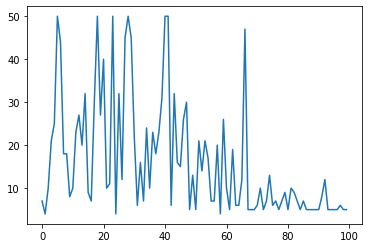

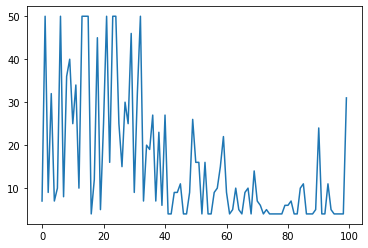

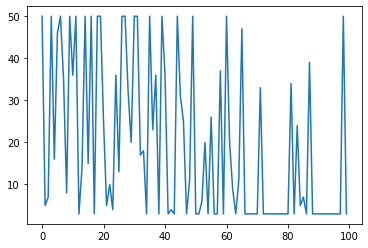

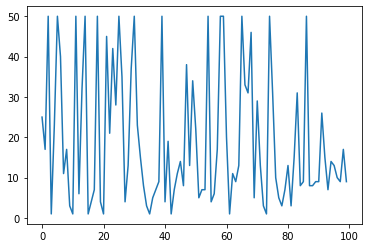

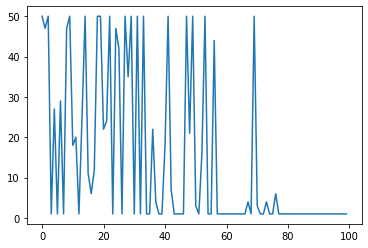

In [37]:
for iii in range(5):
    source = np.random.randint(0,25)
    target = np.random.randint(0,25)
    if source != target :
        iter_ = 100
        iter_actuel = 0
        current_iter = 0
        var_dict = {}
        max_move = 50
        bdw = 20
        cpt = 0
        expirience_replay = {}
        
        summ = 0
        for ii in range(iter_):
            iter_actuel = ii + 1
            current_node = source
            path = ""
            cpt = 0
            solve_var = []
            j = source

            Used_df = pd.DataFrame(np.zeros((1,1)))
            for link in g.edges:
                s_link = get_tuple_to_name(link)
                Used_df[s_link] = g.edges[link]['used']

            flag_finished = False
            while flag_finished != True and cpt < max_move:
                j = get_action (current_node)
                i = current_node
                #print("current node : {}".format(i))
                #print("action taken : {}".format(j))
            
                #print("action taken")
                #Used_df = new_iter_used(Used_df,j,bdw)
                if ((i,j) in get_possible_actions(i)):
                    path += "{}_".format(str((i,j)))
                    solve_var.append((i,j))
                    var_dict[i,j] = 1
                    cpt = cpt +1
                    #print(Used_df.head())
                    if g.edges[i,j]['capacity'] > Used_df.iloc[-1,Used_df.columns.get_loc(get_tuple_to_name((i,j)))] + bdw:
                        #print("Yay")
                        Used_df = new_iter_used(Used_df,j,bdw)
                        current_node = j
                        if j == target:
                            flag_finished = True
                    else:
                        #print("fail")
                        Used_df = new_iter_used(Used_df,j,0)
            path_ = path[:-1]
            solve_var = get_path_as_list_tuples(path_)

            #sum_delay = 0
            #cpt_solve_var = 0
            #for link in solve_var:
            #    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
            #    sum_delay = sum_delay + Used_df.iloc[cpt_solve_var,Used_df.columns.get_loc(s_link)]
            #    cpt_solve_var = cpt_solve_var +1

            ## Draw chosen path red ##
            #draw_path(solve_var)
            dict_res[ii]['nodes'] = len(solve_var)
            give_final_reward(solve_var,len(solve_var))
    plot_graph('nodes')
        

#plot_graph(summ/10)
#print("{} : {}".format(test,summ/10))


In [ ]:
for ii in range(iter_):
    print(dict_res[ii]['nodes'] )

In [ ]:
plot_graph('Sum of delay')

In [ ]:
Delay_df

In [ ]:
sum_delay = 0
cpt_solve_var = 0
for link in solve_var:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    print(s_link)
    sum_delay = sum_delay + Delay_df.iloc[cpt_solve_var,Delay_df.columns.get_loc(s_link)]
    cpt_solve_var = cpt_solve_var +1